Contour plot of ln(evidence) for loss against number of layers\
for limited and not limited thickness

ploting ln(evidence) for changes in $Dq/q$ vs $\lambda$, with $\lambda$ scaleing dR

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel
from sepObjective import getObjective as gO
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from dynesty.utils import quantile as _quantile

from CFitter import CFitter
import make_sim_data as msd
print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))


refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4
refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


In [2]:
def aPlotter(res, interestingNo, spacesize, figI):
    print(figI)
    # no = -1000
    # slc = slice(no-1000,no)
    useAbleLow=0.1
    useAbleHigh=10.
    xall=np.linspace(0,spacesize,len(res["logz"]))
    print("len",len(res["logz"]), "space size", spacesize)
    useable=np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if np.exp(y)>useAbleLow and np.exp(y)<=useAbleHigh]))
    # print(len(res["logz"]),res["logz"][slc])#summary()
    interesting = np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if x>=float(interestingNo)]))#.reshape((2,-2))
    print("len 2", len(interesting[0]), len(interesting), interesting[0,:3])
    print("logz max: ",max(res["logz"]),",min: ",min(res["logz"]))
    print("z max: ",max(np.exp(res["logz"])),",min: ",min(np.exp(res["logz"])))
#     print(res["logz"][:5],interesting[1,:5],useable[1,:5])
    # print("interesting")
#     xall=np.linspace(0,spacesize,len(res["logz"]))
#     xusable=np.linspace(0,spacesize,len(useable))
    plt.figure(figI)
    figI+=1
    plt.plot(xall,res["logz"])
    plt.title("ln(evidence) log scaled vs -ln(X)")
    # plt.yscale("log")
    plt.figure(figI)
    figI+=1
    plt.plot(interesting[0],interesting[1])
    plt.title(r"interesting values ln(evidence)  vs -ln(X) $\geq %d$" % interestingNo)
    if len(useable)>=2:
        plt.figure(figI)
        figI+=1
        plt.plot(useable[0],useable[1])
        plt.title(r"usful values ln(%.3f<evidence $\leq$ %.3f)  vs -ln(X)"%(useAbleLow,useAbleHigh))
    print(figI)
    return figI

In [3]:
figI = 0
# simple structure
thicks_true = [10,120,100,130,10]
bs_true = [0,5,4.5,5,10]
roughs_true = [0,0,0,0,0]
# bs = [5,4.5,5]
# thicks = [120,100,130]
# roughs = [0,0,0]
bs = bs_true
thicks = thicks_true
roughs = roughs_true
loss = 1.
no_layers = len(bs)
no_layers = len(bs_true)
# no_layers = 3
layers = []
names = []
#names = ['layer1','layer2']
for i in range(no_layers):
    names.append('layer'+str(i))
for i in range(no_layers):
        sld = SLD(bs[i],name=names[i])
        layers.append(sld(thicks[i],roughs[i]))
structure = layers[0]
for layer in layers[1:]:
    structure|=layer
print("done")

done


done


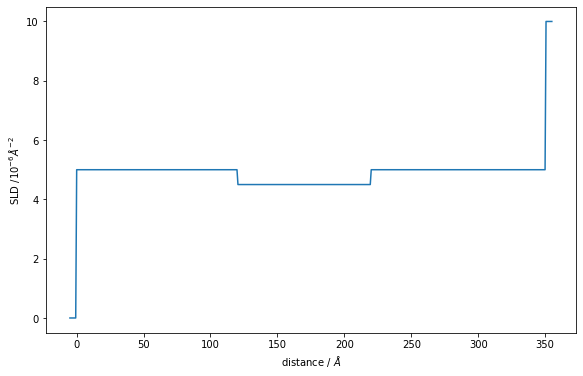

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 6]
#notebook
plt.figure(figI)
figI+=1
plt.plot(*structure.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
print("done")

In [5]:
resolution = 5.
model = ReflectModel(structure, bkg=3e-6, dq=resolution)

csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


<ErrorbarContainer object of 3 artists>

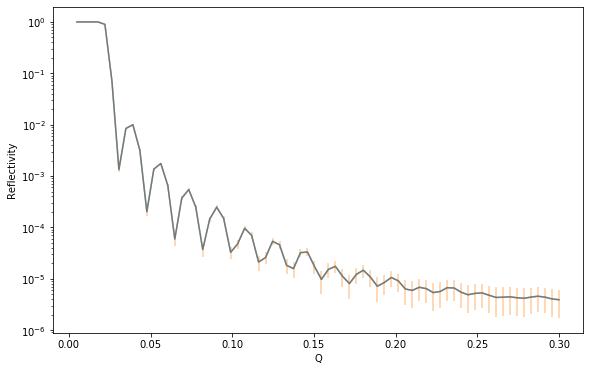

In [6]:
q = np.linspace(0.005, 0.3, 70)
plt.figure(figI)
figI+=1
R = model(q, x_err=resolution)
plt.plot(q, R)
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.yscale('log')
#Q, R(Q), sig_Q, sig_R =
import make_sim_data as msd
sim_dR = msd.main(sim_q=q,sim_R=R)*10
R = model(q, x_err=resolution)
plt.errorbar(q,R,sim_dR, alpha=0.4)

In [7]:
data = Data1D(data= (q,R,sim_dR))

In [8]:
maxLength = 350
def logp_extra(model, data=None):
    returns = 0
    if sum(model.structure.slabs()[1:-1,0])>maxLength:
        returns = -np.inf
    return returns
def getDq(res):
    samples=res["samples"]
    samples = np.atleast_1d(samples)
    weights = np.exp(res['logwt'] - res['logz'][-1])
    x=samples[:,0]
    ql, qm, qh = _quantile(x, [0.025, 0.5, 0.975], weights=weights)
    return qm

In [9]:
resolutions = [1.,3.,7.,9.]
dRScaleBys = [5,10,15,20]
# lnPosts = []
# lnPostss = []
lnEvidence1 = []
lnEvidence2 = []
dq1=[]
dq2=[]
figI=1
# resolution = 5.
for dRScaleBy in dRScaleBys:
#     datas=[]
    for resolution in resolutions:
        model = ReflectModel(structure, bkg=3e-6, dq=resolution)
        q = np.linspace(0.005, 0.3, 70)# was 1001
#         plt.figure(figI)
        figI+=1
        R = model(q, x_err=resolution)
#         plt.plot(q, R)
#         plt.xlabel('Q')
#         plt.ylabel('Reflectivity')
#         plt.yscale('log')
#         plt.title('dR scaled by '+str(dRScaleBy)+' dq '+str(resolution))
        #Q, R(Q), sig_Q, sig_R =
        sim_dR = msd.main(sim_q=q,sim_R=R)*dRScaleBy
#         R = model(q, x_err=resolution)
#         plt.errorbar(q,R,sim_dR, alpha=0.4)
        data = Data1D(data= (q,R,sim_dR))
        print("dRScaleBy:",dRScaleBy,"resolution:",resolution)

        objective = gO(data, 3, fitDq=True, logpExtra=logp_extra)
        fitter = CFitter(objective)
        DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim()) #1:01:10 or 28:46 time
        DNSampler.run_nested(dlogz_init=0.05)# was 0.01
        result = DNSampler.results
        
        dq = getDq(result)
        print("thickness limited dq:",dq)
        dq1.append(dq)
        lnEvidence = result["logz"][-1]
        print("thickness limited lnEvidence:",lnEvidence)
        lnEvidence1.append(lnEvidence)


        objective = gO(data, 3, fitDq=True)
        fitter = CFitter(objective)
        DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim()) #1:01:10 or 28:46 time
        DNSampler.run_nested(dlogz_init=0.05)# was 0.01
        result = DNSampler.results
        
        dq = getDq(result)
        print("thickness limited dq:",dq)
        dq1.append(dq)
        lnEvidence = result["logz"][-1]
        print("lnEvidence:",lnEvidence)
        lnEvidence2.append(lnEvidence)

#         print(lnPost)
#         lnPosts.append(lnPost)

csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 5 resolution: 1.0


32917it [13:36, 40.31it/s, batch: 8 | bound: 209 | nc: 1 | ncall: 179619 | eff(%): 18.326 | loglstar: 139.286 < 147.649 < 147.491 | logz: 122.866 +/-  0.286 | stop:  0.933]             


thickness limited dq: 0.8638837062612781
thickness limited lnEvidence: 122.83944246776682


35193it [15:29, 37.87it/s, batch: 9 | bound: 240 | nc: 5 | ncall: 209314 | eff(%): 16.813 | loglstar: 138.791 < 147.640 < 147.539 | logz: 123.034 +/-  0.283 | stop:  0.928]            


thickness limited dq: 0.876380421328369
lnEvidence: 123.03847223345956
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 5 resolution: 3.0


35425it [11:51, 49.78it/s, batch: 8 | bound: 247 | nc: 4 | ncall: 214684 | eff(%): 16.501 | loglstar: 144.050 < 152.894 < 152.802 | logz: 126.878 +/-  0.291 | stop:  0.848]             


thickness limited dq: 2.980476946969178
thickness limited lnEvidence: 126.88576544778431


30815it [11:44, 43.71it/s, batch: 7 | bound: 257 | nc: 2 | ncall: 223091 | eff(%): 13.813 | loglstar: 144.554 < 152.887 < 152.707 | logz: 126.833 +/-  0.293 | stop:  0.977]             


thickness limited dq: 2.981298073148631
lnEvidence: 126.83792856235517
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 5 resolution: 7.0


32703it [12:59, 41.97it/s, batch: 8 | bound: 337 | nc: 3 | ncall: 310341 | eff(%): 10.538 | loglstar: 150.241 < 159.171 < 159.072 | logz: 134.578 +/-  0.280 | stop:  0.976]            


thickness limited dq: 6.935961768726146
thickness limited lnEvidence: 134.5752451345632


26388it [10:43, 40.98it/s, batch: 7 | bound: 255 | nc: 13 | ncall: 235408 | eff(%): 11.209 | loglstar: 150.536 < 158.702 < 156.341 | logz: 134.613 +/-  0.281 | stop:  0.941]            


thickness limited dq: 6.935943485199469
lnEvidence: 134.6244501382069
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 5 resolution: 9.0


34756it [14:42, 39.40it/s, batch: 9 | bound: 402 | nc: 2 | ncall: 348041 | eff(%):  9.986 | loglstar: 150.987 < 160.522 < 160.375 | logz: 137.436 +/-  0.268 | stop:  0.858]            


thickness limited dq: 9.039485166444791
thickness limited lnEvidence: 137.44987385526872


26765it [10:20, 43.13it/s, batch: 7 | bound: 261 | nc: 2 | ncall: 238568 | eff(%): 11.219 | loglstar: 151.837 < 160.387 < 158.517 | logz: 136.901 +/-  0.275 | stop:  0.964]            


thickness limited dq: 9.039800778470166
lnEvidence: 136.8824196606936
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 10 resolution: 1.0


27971it [12:46, 36.51it/s, batch: 7 | bound: 201 | nc: 7 | ncall: 180980 | eff(%): 15.455 | loglstar: 90.758 < 99.130 < 99.002 | logz: 79.007 +/-  0.251 | stop:  0.972]              


thickness limited dq: 0.9196871510655286
thickness limited lnEvidence: 79.02962471868834


29099it [16:23, 29.58it/s, batch: 7 | bound: 272 | nc: 3 | ncall: 240084 | eff(%): 12.120 | loglstar: 90.584 < 99.129 < 99.003 | logz: 79.110 +/-  0.250 | stop:  0.947]              


thickness limited dq: 0.9272458863166831
lnEvidence: 79.14634609469474
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 10 resolution: 3.0


24424it [11:23, 35.73it/s, batch: 7 | bound: 191 | nc: 82 | ncall: 216434 | eff(%): 11.285 | loglstar: 95.892 < 104.016 < 102.181 | logz: 83.666 +/-  0.254 | stop:  0.963]           


thickness limited dq: 2.982218960918321
thickness limited lnEvidence: 83.69378302977215


25208it [09:41, 43.33it/s, batch: 7 | bound: 194 | nc: 1 | ncall: 173967 | eff(%): 14.490 | loglstar: 95.856 < 104.049 < 102.389 | logz: 83.422 +/-  0.255 | stop:  0.964]            


thickness limited dq: 2.9855061460085475
lnEvidence: 83.44066465958068
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 10 resolution: 7.0


21792it [09:02, 40.15it/s, batch: 7 | bound: 190 | nc: 2 | ncall: 198957 | eff(%): 10.953 | loglstar: 102.092 < 108.705 < 102.621 | logz: 91.359 +/-  0.240 | stop:  0.947]           


thickness limited dq: 6.925476704806866
thickness limited lnEvidence: 91.39816629996136


29203it [12:41, 38.34it/s, batch: 8 | bound: 301 | nc: 26 | ncall: 294861 | eff(%):  9.904 | loglstar: 101.575 < 110.614 < 110.452 | logz: 91.237 +/-  0.241 | stop:  0.987]          


thickness limited dq: 6.928173693510724
lnEvidence: 91.24560871848851
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 10 resolution: 9.0


31567it [12:38, 41.62it/s, batch: 8 | bound: 303 | nc: 2 | ncall: 301314 | eff(%): 10.476 | loglstar: 102.948 < 112.001 < 111.910 | logz: 93.620 +/-  0.233 | stop:  0.910]           


thickness limited dq: 9.055262758808986
thickness limited lnEvidence: 93.67078560983974


31627it [13:08, 40.12it/s, batch: 8 | bound: 271 | nc: 8 | ncall: 310031 | eff(%): 10.201 | loglstar: 102.703 < 111.746 < 109.721 | logz: 93.585 +/-  0.229 | stop:  0.917]           


thickness limited dq: 9.044272729703877
lnEvidence: 93.58957528112938
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 15 resolution: 1.0


25170it [16:40, 25.15it/s, batch: 8 | bound: 227 | nc: 1 | ncall: 250344 | eff(%): 10.054 | loglstar: 62.165 < 70.658 < 69.551 | logz: 53.402 +/-  0.227 | stop:  0.994]             


thickness limited dq: 1.0042726832521294
thickness limited lnEvidence: 53.42875076435442


25056it [24:41, 16.92it/s, batch: 8 | bound: 283 | nc: 39 | ncall: 398866 | eff(%):  6.282 | loglstar: 62.278 < 70.715 < 69.112 | logz: 53.369 +/-  0.229 | stop:  0.935]             


thickness limited dq: 1.0002095506747959
lnEvidence: 53.350219401956416
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 15 resolution: 3.0


31147it [14:58, 34.68it/s, batch: 8 | bound: 309 | nc: 1 | ncall: 286439 | eff(%): 10.874 | loglstar: 66.513 < 75.597 < 73.630 | logz: 58.311 +/-  0.222 | stop:  0.908]              


thickness limited dq: 2.983419454443224
thickness limited lnEvidence: 58.30248768845667


32714it [21:58, 24.82it/s, batch: 8 | bound: 429 | nc: 3 | ncall: 451174 | eff(%):  7.251 | loglstar: 66.662 < 76.005 < 75.947 | logz: 58.254 +/-  0.225 | stop:  0.870]              


thickness limited dq: 2.9844180784280017
lnEvidence: 58.243933207135605
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 15 resolution: 7.0


20138it [16:14, 20.67it/s, batch: 6 | bound: 224 | nc: 22 | ncall: 285993 | eff(%):  7.041 | loglstar: 73.953 < 82.025 < 80.769 | logz: 65.615 +/-  0.221 | stop:  0.995]            


thickness limited dq: 6.9197833673885345
thickness limited lnEvidence: 65.62275468115784


27831it [14:06, 32.90it/s, batch: 7 | bound: 302 | nc: 29 | ncall: 321482 | eff(%):  8.657 | loglstar: 73.055 < 81.903 < 80.003 | logz: 66.153 +/-  0.208 | stop:  0.973]            


thickness limited dq: 6.913474675659614
lnEvidence: 66.1844137487033
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 15 resolution: 9.0


30071it [22:20, 22.43it/s, batch: 8 | bound: 458 | nc: 4 | ncall: 548430 | eff(%):  5.483 | loglstar: 74.073 < 83.197 < 81.172 | logz: 68.085 +/-  0.204 | stop:  0.939]             


thickness limited dq: 9.014474836293898
thickness limited lnEvidence: 68.1141313737001


27511it [16:56, 27.07it/s, batch: 7 | bound: 393 | nc: 7 | ncall: 422907 | eff(%):  6.505 | loglstar: 74.701 < 83.624 < 83.467 | logz: 67.780 +/-  0.212 | stop:  0.949]             


thickness limited dq: 9.016231102188632
lnEvidence: 67.76457078788303
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 20 resolution: 1.0


21500it [39:23,  9.10it/s, batch: 7 | bound: 540 | nc: 7 | ncall: 646445 | eff(%):  3.326 | loglstar: 42.602 < 50.214 < 48.638 | logz: 35.085 +/-  0.212 | stop:  0.996]             


thickness limited dq: 1.08556403773735
thickness limited lnEvidence: 35.082274779157665


21764it [38:44,  9.36it/s, batch: 7 | bound: 537 | nc: 2090 | ncall: 600285 | eff(%):  3.626 | loglstar: 42.222 < 50.408 < 48.367 | logz: 35.502 +/-  0.207 | stop:  0.974]          


thickness limited dq: 1.090205326712778
lnEvidence: 35.44151413337935
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 20 resolution: 3.0


29745it [18:35, 26.66it/s, batch: 8 | bound: 333 | nc: 11 | ncall: 332506 | eff(%):  8.946 | loglstar: 46.043 < 55.324 < 53.496 | logz: 40.073 +/-  0.204 | stop:  0.901]            


thickness limited dq: 2.991158350944905
thickness limited lnEvidence: 40.031656321251766


27554it [19:58, 22.98it/s, batch: 7 | bound: 335 | nc: 24 | ncall: 369351 | eff(%):  7.460 | loglstar: 46.619 < 55.426 < 53.633 | logz: 40.089 +/-  0.204 | stop:  0.993]           


thickness limited dq: 2.9922838570962345
lnEvidence: 40.10555017631356
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 20 resolution: 7.0


28981it [16:40, 28.96it/s, batch: 8 | bound: 342 | nc: 2 | ncall: 358778 | eff(%):  8.078 | loglstar: 52.594 < 62.126 < 61.993 | logz: 47.851 +/-  0.197 | stop:  0.971]           


thickness limited dq: 6.896646297972955
thickness limited lnEvidence: 47.87006583802985


29292it [12:38, 38.62it/s, batch: 8 | bound: 274 | nc: 15 | ncall: 253534 | eff(%): 11.553 | loglstar: 52.798 < 62.120 < 62.003 | logz: 47.598 +/-  0.200 | stop:  0.849]          


thickness limited dq: 6.8946791735857165
lnEvidence: 47.631013960883735
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
dRScaleBy: 20 resolution: 9.0


26560it [14:31, 30.47it/s, batch: 7 | bound: 366 | nc: 1 | ncall: 326971 | eff(%):  8.123 | loglstar: 54.756 < 63.481 < 63.362 | logz: 49.796 +/-  0.194 | stop:  0.999]           


thickness limited dq: 8.97128377290011
thickness limited lnEvidence: 49.81562050590138


20234it [12:34, 26.83it/s, batch: 7 | bound: 308 | nc: 3 | ncall: 274067 | eff(%):  7.383 | loglstar: 55.198 < 63.232 < 61.283 | logz: 49.917 +/-  0.194 | stop:  0.926]           


thickness limited dq: 8.965052073398468
lnEvidence: 49.91129398629351


In [11]:
f=open("dDqDR2DupdatedFittingDq.txt","w+")
f.write("limited max thickness ln(evidence):\n")
for lnEvidence in lnEvidence1:
    f.write(str(lnEvidence))
f.write("\nnot limited max thickness ln(evidence):\n")
for lnEvidence in lnEvidence2:
    f.write(str(lnEvidence))
f.close()

thickness limited ln(Evidence): [122.83944246776682, 126.88576544778431, 134.5752451345632, 137.44987385526872, 79.02962471868834, 83.69378302977215, 91.39816629996136, 93.67078560983974, 53.42875076435442, 58.30248768845667, 65.62275468115784, 68.1141313737001, 35.082274779157665, 40.031656321251766, 47.87006583802985, 49.81562050590138]
not thickness limited ln(Evidence): [123.03847223345956, 126.83792856235517, 134.6244501382069, 136.8824196606936, 79.14634609469474, 83.44066465958068, 91.24560871848851, 93.58957528112938, 53.350219401956416, 58.243933207135605, 66.1844137487033, 67.76457078788303, 35.44151413337935, 40.10555017631356, 47.631013960883735, 49.91129398629351]


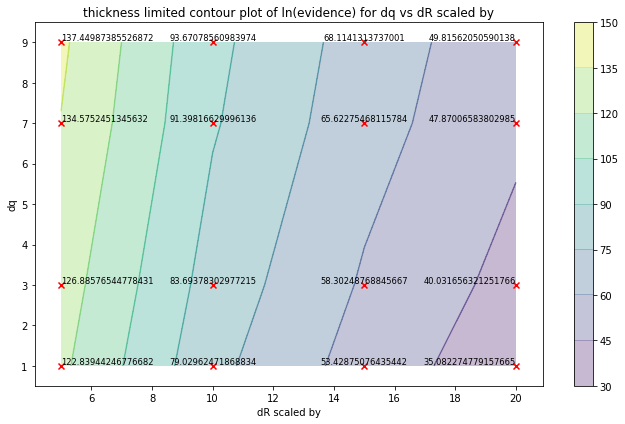

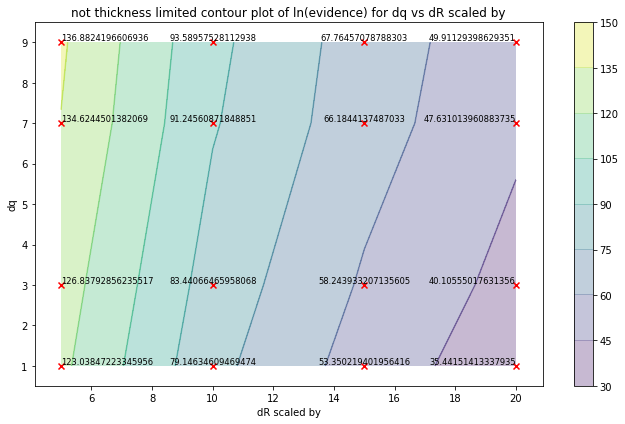

Wall time: 678 ms


In [10]:
%%time

ha_s = ["left", "center", "center", "right"]

print("thickness limited ln(Evidence):",lnEvidence1)
print("not thickness limited ln(Evidence):",lnEvidence2)

zs= np.array(lnEvidence1).reshape(len(resolutions), len(dRScaleBys)).transpose()
plt.figure(figI)
figI+=1
plt.contour(dRScaleBys,resolutions,zs,alpha=0.5);
plt.contourf(dRScaleBys,resolutions,zs,alpha=0.3);
plt.colorbar();
for i in range(len(dRScaleBys)):#x in losses:
    for j in range(len(resolutions)): #y in nLayers:
        plt.scatter(dRScaleBys[i],resolutions[j],c="red",marker="x");
        ha = ha_s[i]
        plt.annotate(zs[j][i],(dRScaleBys[i],resolutions[j]),
                    horizontalalignment=ha, fontsize="small", verticalalignment='bottom')
# for x in dRScaleBys:
#     for y in resolutions:
#         plt.scatter(x,y,c="red",marker="x");
plt.ylabel("dq");
plt.xlabel("dR scaled by");
plt.title("thickness limited contour plot of ln(evidence) for dq vs dR scaled by");
plt.tight_layout();
plt.show();
#--------

zs= np.array(lnEvidence2).reshape(len(resolutions), len(dRScaleBys)).transpose()
plt.figure(figI)
figI+=1
plt.contour(dRScaleBys,resolutions,zs,alpha=0.5);
plt.contourf(dRScaleBys,resolutions,zs,alpha=0.3);
plt.colorbar();
for i in range(len(dRScaleBys)):#x in losses:
    for j in range(len(resolutions)): #y in nLayers:
        plt.scatter(dRScaleBys[i],resolutions[j],c="red",marker="x");
        ha = ha_s[i]
        plt.annotate(zs[j][i],(dRScaleBys[i],resolutions[j]),
                    horizontalalignment=ha, fontsize="small", verticalalignment='bottom')
# for x in dRScaleBys:
#     for y in resolutions:
#         plt.scatter(x,y,c="red",marker="x");
plt.ylabel("dq");
plt.xlabel("dR scaled by");
plt.title("not thickness limited contour plot of ln(evidence) for dq vs dR scaled by");
plt.tight_layout();
plt.show();

17

-220.11328681456592, 982.7887810159078, 1055.2684365805314, -146.47705209627895, -220.60610280345477, 982.9960603373407, 1055.0312970246378, -146.91675261007052, -220.6032067872486, 982.54792841728, 1054.832846010915, -146.635041601231, -220.51950736917618, 982.9139570644866, 1054.9575362870723, -147.6220194411551

thickness limited ln(Evidence): [123.16991708181622, 127.28354739544655, 134.61638873366377, 137.0488816288748, 79.31487768802788, 83.61806459166255, 91.25241880270148, 93.50029804522991, 53.478475594721246, 58.26188563153771, 66.08372649448502, 68.00908270425906, 35.37150962851595, 40.07964777417287, 47.69914890629723, 49.86566881229127]
not thickness limited ln(Evidence): [123.21523793905101, 127.52930709063281, 134.58277656980152, 136.96818686787142, 79.39908711758378, 83.45238903221752, 91.4792363050359, 93.4648497466821, 53.47936510068129, 57.85082279388238, 65.57975531289618, 68.0737023369191, 35.55933383746204, 40.01223329808199, 47.74457085688211, 49.8457247837232]


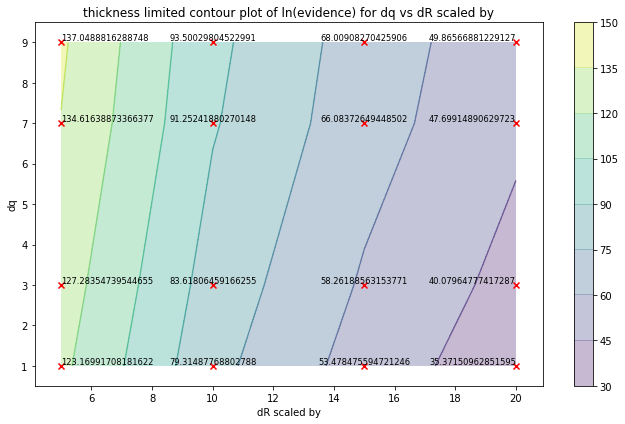

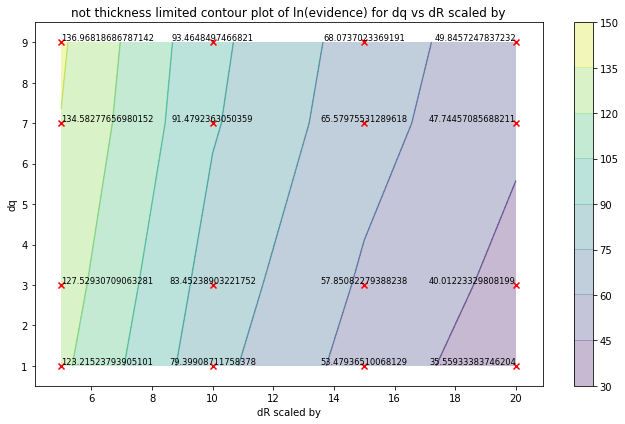

Wall time: 641 ms


In [13]:
%%time

ha_s = ["left", "center", "center", "right"]

print("thickness limited ln(Evidence):",lnEvidence1)
print("not thickness limited ln(Evidence):",lnEvidence2)

zs= np.array(lnEvidence1).reshape(len(resolutions), len(dRScaleBys)).transpose()
plt.figure(figI)
figI+=1
plt.contour(dRScaleBys,resolutions,zs,alpha=0.5);
plt.contourf(dRScaleBys,resolutions,zs,alpha=0.3);
plt.colorbar();
for i in range(len(dRScaleBys)):#x in losses:
    for j in range(len(resolutions)): #y in nLayers:
        plt.scatter(dRScaleBys[i],resolutions[j],c="red",marker="x");
        ha = ha_s[i]
        plt.annotate(zs[j][i],(dRScaleBys[i],resolutions[j]),
                    horizontalalignment=ha, fontsize="small", verticalalignment='bottom')
# for x in dRScaleBys:
#     for y in resolutions:
#         plt.scatter(x,y,c="red",marker="x");
plt.ylabel("dq");
plt.xlabel("dR scaled by");
plt.title("thickness limited contour plot of ln(evidence) for dq vs dR scaled by");
plt.tight_layout();
plt.show();
#--------

zs= np.array(lnEvidence2).reshape(len(resolutions), len(dRScaleBys)).transpose()
plt.figure(figI)
figI+=1
plt.contour(dRScaleBys,resolutions,zs,alpha=0.5);
plt.contourf(dRScaleBys,resolutions,zs,alpha=0.3);
plt.colorbar();
for i in range(len(dRScaleBys)):#x in losses:
    for j in range(len(resolutions)): #y in nLayers:
        plt.scatter(dRScaleBys[i],resolutions[j],c="red",marker="x");
        ha = ha_s[i]
        plt.annotate(zs[j][i],(dRScaleBys[i],resolutions[j]),
                    horizontalalignment=ha, fontsize="small", verticalalignment='bottom')
# for x in dRScaleBys:
#     for y in resolutions:
#         plt.scatter(x,y,c="red",marker="x");
plt.ylabel("dq");
plt.xlabel("dR scaled by");
plt.title("not thickness limited contour plot of ln(evidence) for dq vs dR scaled by");
plt.tight_layout();
plt.show();

thickness limited ln(Evidence): [123.16991708181622, 127.28354739544655, \134.61638873366377, 137.0488816288748, 79.31487768802788, 83.61806459166255, \91.25241880270148, 93.50029804522991, 53.478475594721246, 58.26188563153771, \66.08372649448502, 68.00908270425906, 35.37150962851595, 40.07964777417287, \47.69914890629723, 49.86566881229127]\
not thickness limited ln(Evidence): [123.21523793905101, 127.52930709063281, \134.58277656980152, 136.96818686787142, 79.39908711758378, 83.45238903221752, \91.4792363050359, 93.4648497466821, 53.47936510068129, 57.85082279388238, \65.57975531289618, 68.0737023369191, 35.55933383746204, 40.01223329808199, \47.74457085688211, 49.8457247837232]

In [ ]:
# for objective1,objective2 in zip(objectives1,objectives2):
#     plt.figure(figI)
#     figI+=1

#     plt.subplot(2,2,1).set_title("data plotted for limited max thickness")
#     fig, ax = objective1.plot()
#     plt.subplot(2,2,2).set_title("structure plotted for limited max thickness")
#     plt.plot(*objective1.model.structure.sld_profile())
#     plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
#     plt.xlabel('distance / $\AA$');

#     plt.subplot(2,2,3).set_title("data plotted for limited max thickness")
#     fig, ax = objective2.plot()
#     plt.subplot(2,2,4).set_title("structure plotted for limited max thickness")
#     plt.plot(*objective2.model.structure.sld_profile())
#     plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
#     plt.xlabel('distance / $\AA$');
